# Data Collection

The original dataset, US Domestic Flights Delay Prediction (2013 - 2018) (Source: [Kaggle](https://www.kaggle.com/datasets/gabrielluizone/us-domestic-flights-delay-prediction-2013-2018)), is provided as a zip archive of 1.54 GB. When decompressed, the archive contains 60 files with a total size of 13.6 GB. Each file corresponds to one month of data, starting from January 2014 and ending in December 2018.

Steps for collecting and cleaning the data:

*	Loading the first file
*	Evaluating the data’s size and quality
*	Defining the specific data needed for the project
*	Developing a process for data organization and cleaning
*	Testing the code on one month’s data file
*	Applying the code to all files
*	Accumulating the complete dataset


The archive file (csv_flight.zip) was downloaded and saved locally.

## Loading the first file

In [1]:
import zipfile
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil import tz
from time import time
import pickle
import scipy.stats as st

os.chdir('/Users/a.kholodov/Documents/02. Personal/20. Education/50. Universities/Springboard/Springboard_git/Springboard _repo/CS2-flights-delay-REPO')

# pd.set_option('display.max_rows', 130)
# pd.set_option('display.width', 200)

# Loading timezones for IATA codes of airports
IATAtz_df = pd.read_csv('https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap', 
                        sep = '\t', 
                        index_col=0, 
                        header=None)

# Dictionary with IATA codes as keys and timezones as values
IATAtz = IATAtz_df.to_dict('dict')[1]
del(IATAtz_df)

# List of dates of start/end of DST
DST = pd.to_datetime(['2014-03-09', '2014-11-02', '2015-03-08', '2015-11-01', 
       '2016-03-13', '2016-11-06', '2017-03-12', '2017-11-05', 
       '2018-03-11', '2018-11-04'])


In [ ]:
source_zip_file = 'data/interim/csv_flight.zip'
data_file = 'csv_flight/report_2014_1.csv'

# reading the first file to evaluate the data
with zipfile.ZipFile(source_zip_file) as zip_source:
    with zip_source.open(data_file) as data_file:
        flights_2014_1 = pd.read_csv(data_file, low_memory=False)

## Data size

In [ ]:
print(flights_2014_1.shape)
print(flights_2014_1.info())

The data for one month contains 471,949 rows and 110 columns, with a total memory size of 396 MB. The estimated size of the entire dataset, without reorganization or cleaning, may exceed 23 GB, which could be challenging to process locally. Therefore, one of the goals of data preparation will be to reduce the dataset size without compromising quality.

## Data structure and check
### Date of the flight

In [ ]:
flights_2014_1.iloc[:,:6].head()

0. **Year**
    * **Description:** Year
    * **Data type:** int16
    * **Drop**
    * **Comment:** We have a flight date which includes this data

1. **Quarter**  
    * **Description:** Quarter (1-4)  
    * **Data type:** int8
    * **Drop**
    * **Comment:** We have a flight date which includes this data

2. **Month**  
    * **Description:** Month (1-12)  
    * **Data type:** int8
    * **Drop**
    * **Comment:** We have a flight date which includes this data

3. **DayofMonth**  
    * **Description:** Day of month  
    * **Data type:** int8
    * **Drop**
    * **Comment:** We have a flight date which includes this data

4. **DayOfWeek**  
    * **Description:** Day of week  
    * **Data type:** int8
    * **Drop**
    * **Comment:** We have a flight date which includes this data

5. **FlightDate**  
    * **Description:** Flight Date (yyyymmdd)
    * **Data type:** datetime
    * **Keep**

Values check for Date of the flight: the data accurate, there is no outliers or NA.

In [ ]:
flights_2014_1['FlightDate'].describe()

In [ ]:
flights_2014_1['FlightDate'].value_counts()

But we need to change the data type during the data transformation from current type to datetime.

In [ ]:
flights_2014_1['FlightDate'].info()

In [ ]:
flights_2014_1['FlightDate'].isna().sum()

###  Airline's and flight's details 

In [ ]:
flights_2014_1.iloc[:, 6:10].head()


6. **Reporting_Airline**
    * **Description:**  Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years. 
    * **Data type:** category 
    * **Keep**
    * **Comment:** I decided to keep this field and drop DOT_ID_Reporting_Airline and IATA_CODE_Reporting_Airline because it is declared as unique and recomended by data provider as such | 

7. **DOT_ID_Reporting_Airline**
    * **Description** An identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.
    * **Drop**
    * **Comment:** Not unique
    
8. **IATA_CODE_Reporting_Airline**
    * **Description:** Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique. For analysis, use the Unique Carrier Code.
    * **Drop**
    * **Comment:** Not unique

9. **Tail_Number**
    * **Description:** Tail Number
    * **Drop**
    * **Comment:** Irrelevant to the purposes of the project

10. **Flight_Number_Reporting_Airline**
    * **Description:** Flight Number
    * **Data type:** int16
    * **Keep**
    * **Comment:** Unique number of the flight at a specific day/time

In [ ]:
flights_2014_1.iloc[:, 6].unique()

In [ ]:
flights_2014_1['Flight_Number_Reporting_Airline'].describe()

In [ ]:
flights_2014_1[['Reporting_Airline', 'Flight_Number_Reporting_Airline']].info()

In [ ]:
flights_2014_1[['Reporting_Airline', 'Flight_Number_Reporting_Airline']].isna().sum()

The data in the fields Reporting_Airline and Flight_Number_Reporting_Airline is accurate, there is no outliers or NA, But I need to change the data type during the data transformation.

###  Origin and Destination detailes

In [ ]:
DestFields = ['DestAirportID', 
                'DestAirportSeqID', 
                'DestCityMarketID',
                'Dest',
                'DestCityName',
                'DestState',
                'DestStateFips',
                'DestStateName',
                'DestWac']
flights_2014_1.loc[:5, DestFields]

In [ ]:
OriginFields = ['OriginAirportID', 
                'OriginAirportSeqID', 
                'OriginCityMarketID',
                'Origin',
                'OriginCityName',
                'OriginState',
                'OriginStateFips',
                'OriginStateName',
                'OriginWac']
flights_2014_1.loc[:5, OriginFields]

Origin and Destination data has the same structure so I will treat it the same way.

11.	**OriginAirportID / 20. DestAirportID**  
    * **Description:** Origin/Destination Airport, Airport ID. An identification number assigned by US DOT to identify a unique airport. Use this field for airport analysis across a range of years because an airport can change its airport code and airport codes can be reused.  
    * **Data type:** category  
    * **Keep**  
    * **Comment:** I decided to keep these codes because of its uniqueness, assuared by data provider.  
    
12.	**OriginAirportSeqID / 21. DestAirportSeqID**  
    * **Description:** Origin/Destination Airport, Airport Sequence ID. An identification number assigned by US DOT to identify a unique airport at a given point of time. Airport attributes, such as airport name or coordinates, may change over time.
    * **Drop**
13.	**OriginCityMarketID / 22. DestCityMarketID**
    * **Description:** Origin/Destination Airport, City Market ID. City Market ID is an identification number assigned by US DOT to identify a city market. Use this field to consolidate airports serving the same city market.
    * **Drop**
14.	**Origin / 23. Dest**
    * **Description:** Origin/Destination Airport
    * **Data type:** category
    * **Keep**
    * **Comment:** This core is IATA code of the airport, which is represented in most traveling documents. It could be useful in the model.
15.	**OriginCityName / 24. DestCityName**
    * **Description:** Origin/Destination Airport, City Name
    * **Drop**
16.	**OriginState / 25. DestState**
    * **Description:** Origin/Destination Airport, State Code
    * **Drop**
17.	**OriginStateFips / 26. DestStateFips**
    * **Description:** Origin/Destination Airport, State Fips
    * **Drop**
18.	**OriginStateName / 27. DestStateName**
    * **Description:** Origin/Destination Airport, State Name
    * **Drop**
19.	**OriginWac / 28. DestWac**
    * **Description:** Origin/Destination Airport, World Area Code
    * **Drop**

In [ ]:
flights_2014_1.loc[:, 'OriginAirportID'].unique()

In [ ]:
flights_2014_1.loc[:, 'DestAirportID'].unique()

In [ ]:
flights_2014_1.loc[:, 'Origin'].unique()

In [ ]:
flights_2014_1.loc[:, 'Dest'].unique()

In [ ]:
# Check for equal number of Origin Airport IDs and Origin (IATA codes)
print('Number of unique OriginAirport IDs:', flights_2014_1.loc[:, 'OriginAirportID'].nunique(),
      '\nNumber of unique Origin codes:', flights_2014_1.loc[:, 'Origin'].nunique())

In [ ]:
# Check for equal number of Origin Airport IDs and Origin (IATA codes)
print('Number of unique DestAirport IDs:', flights_2014_1.loc[:, 'DestAirportID'].nunique(),
      '\nNumber of unique Destination codes:', flights_2014_1.loc[:, 'Dest'].nunique())

In [ ]:
# Check for NA-values in the fields, I suppose to keep
flights_2014_1[['OriginAirportID', 'Origin', 'DestAirportID', 'Dest']].isna().sum()

The numbers of unique code for OriginalAirportID/DestAirportID and Origin/Dest are equal, and they don't have NA-values.

###  Departure and Arrival times (scheduled and actual)

In [ ]:
# Sample of the block of data for departure times
DepFields = ['CRSDepTime', 
             'DepTime',
             'DepDelay',
             'DepDelayMinutes',
             'DepDel15',
             'DepartureDelayGroups',
             'DepTimeBlk']
flights_2014_1.loc[:5, DepFields]

In [ ]:
# Sample of the block of data for arrival times
ArrFields = ['CRSArrTime', 
             'ArrTime',
             'ArrDelay',
             'ArrDelayMinutes',
             'ArrDel15',
             'ArrivalDelayGroups',
             'ArrTimeBlk']
flights_2014_1.loc[:5, ArrFields]

Two groups of data (for Departure and Arrival time) have the same stricture and similar meaning (with difference in departure or arrival), so I group and describe them togethher.

All time date in dataset is integer in format HHMM. I think for the further analysis it's worth to convert it into the number of minutes from the start of the day.

29.	**CRSDepTime  40. CRSArrTime** 
    * **Description:** CRS Departure/Arrival Time (local time: hhmm)
    * **Data type:** float
    * **Keep**
    * **Comment:** CRS (Computer Reservation System) represents the scuduled time for the flight. I decided to keep this data at this stage becuase it's not clear yet which will be the drivers of the future model - time or categorical time blocks, such as DepTimeBlk or ArrTimeBlk. I suppose to make this decision later. Needs to conver to the number of minutes.
30.	**DepTime  41. ArrTime**  
    * **Description:** Actual Departure/Arrival Time (local time: hhmm)
    * **Data type:** float
    * **Keep**
    * **Comment:** Needs to conver to the number of minutes.
31.	**DepDelay  42. ArrDelay**  
    * **Description:** Difference in minutes between scheduled and actual departure/arrival time. Early departures/arrival show negative numbers.
    * **Data type:** float
    * **Keep**
32.	**DepDelayMinutes  43. ArrDelayMinutes**
    * **Description:** Difference in minutes between scheduled and actual departure/arrival time. Early departures/arrival set to 0.
    * **Drop**
    * **Comment:** This data dublicates partially the field DepDelay and ArrDelay with only differency that this data doesnt't show the negative values - departures or arrivals earlier
33.	**DepDel15  44. ArrDel15**
    * **Description:** Departure/Arrival Delay Indicator, 15 Minutes or More (1=Yes)
    * **Drop**
    * **Comment:** This field represents a boolean data indicating wheather or not the flight delayed. We have the same, and even more detailed information, in the fields with the delay in minutes
34.	**DepartureDelayGroups  45. ArrivalDelayGroups**
    * **Description:** Departure/Arrival Delay intervals, every (15 minutes from <-15 to >180)
    * **Data type:** category
    * **Keep**
    * **Comment:** This categorical data can be useful for prediction model instead of actual delay time. We have to decide and choose it later.
35.	**DepTimeBlk  46. ArrTimeBlk**
    * **Description:** CRS Departure Time Block, Hourly Intervals
    * **Data type:** category
    * **Keep**
    * **Comment:** This categorical data probably will be more usefull for the prediction model comparing to the acrual departure or arrival times in minutes. 

The folllowing data represent some time and duration for processes which I think highly correlated with data described above. I suppose this data (below) doesn't add any value to the prediction model, and I am going to DROP it.  
36.	TaxiOut: Taxi Out Time, in Minutes  
37.	WheelsOff: Wheels Off Time (local time: hhmm)  
38.	WheelsOn: Wheels On Time (local time: hhmm)  
39.	TaxiIn: Taxi In Time, in Minutes  



Let's check the fields supposed to be kept for null values and incosistent data 

In [ ]:
# Check for values of the Departure block fields
flights_2014_1.loc[:, DepFields].describe()

In [ ]:
# Check for values of the Arrival block fields
flights_2014_1.loc[:, ArrFields].describe()

In [ ]:
# Check for NA-values in the Departure block fields
flights_2014_1.loc[:, DepFields].isna().sum()

In [ ]:
# Check for NA-values in the Arrival block fields
flights_2014_1.loc[:, ArrFields].isna().sum()

In [ ]:
print(flights_2014_1['DepartureDelayGroups'].unique())
print(flights_2014_1['ArrivalDelayGroups'].unique())

In [ ]:
print(sorted(flights_2014_1['DepTimeBlk'].unique()))
print(sorted(flights_2014_1['ArrTimeBlk'].unique()))

#### Problems to analyse and solve:
1. **DepTime** and **ArrTime** contain time values '2400' (at the same time CRS times contain only 2359). I have to convert it into 0h00m of the next day.
2. It is needed to convert time into simple number of minutes from the start of the day.
3. DepTime has the same number of NA-values as DepDelay, but ArrTime and ArrDelay have number of NA-values different of those from NA-values in DepTime and DepDelay. Reason can be related to cancelled and diverted flights. There is need to check.
4. Delay Groups (Arrival and Departure) contain NaN values. Need to investigate.

In [ ]:
# Test that all flight wtth NA Departure Time (DepTime) were cancelled
print('The Cancelled field has only these values:', flights_2014_1['Cancelled'].unique())
print('In this dataset there are', int(flights_2014_1['Cancelled'].sum()), 'cancelled flights in total')
print('Among', flights_2014_1.DepTime.isna().sum(), 'flights with NA DepTime there are', 
      flights_2014_1[flights_2014_1.DepTime.isna()]['Cancelled'].count(),'cancelled flights')

Ok. We see that all NA-values in DepTime field are explained by the flight cancellaiton. 
However, there is one more interesting thing: the total number of cancelled flight is higher than the number of NA-values in DepTime field. Does it mean that these flight were cancelled but still have departure time? Let's take a look at this. 

In [ ]:
# How many Cancelled and Diverted flight are there in total?
flights_2014_1[['Cancelled', 'Diverted']].agg('sum')

In [ ]:
# What is a split of flights with/NA Departure Time vs. Cancelled and Diverted flights 
flights_2014_1.groupby(flights_2014_1['DepTime'].isna())[['Cancelled', 'Diverted']].agg('sum')

In [ ]:
# Check all cancelled flight with existing departure time don't have Time in Air (flight time)
departured_cancelled_flights = (~flights_2014_1['DepTime'].isna()) & (flights_2014_1['Cancelled'] == 1)
print('Are all flights depatured but cancelled times have NA as AirTime?',
      flights_2014_1[departured_cancelled_flights]['AirTime'].isna().all())

In [ ]:
# Investigating which flights have NA DepartureDelayGroups
NA_DepDelay_group = flights_2014_1['DepartureDelayGroups'].isna()
print('Number of NA_values in DepartureDelayGoups:', NA_DepDelay_group.sum())

cancelled_before_depurture = flights_2014_1['DepTime'].isna() & (flights_2014_1['Cancelled'] == 1)
print('Are all cancelled prior departure flights have NA-value in DepartureDelayGroups?',
      flights_2014_1[cancelled_before_depurture]['DepartureDelayGroups'].isna().all())

1. Departured flights still could be cancelled after departure (didn't take off, ruturned to gate) OR diverted to a different destination.
2. All flight with NA actual Departure Time ('DepTime' field) were canceled and have NA-Value in DepartureDelayGroups

Let’s examine the Arrival times in more detail.

In [ ]:
# What is a split of flights with/NA Arrival Time vs. Cancelled and Diverted flights 
flights_2014_1.groupby(flights_2014_1['ArrTime'].isna())[['Cancelled', 'Diverted']].agg('sum')

From this split it is interesting that some diverted (directed to other airports) flights still have Arrival time. What does this arravel time mean? Is it the arrival time to the Destination airport or the airport where the flight had beed diverted?
Le't examine this question using the field 'DivReachedDest' marking the flights reached Destination after being diverted.

In [ ]:
# Check the numbers from diverted flights' split over w/NA ArrTime 
diverted_but_arrived = (~flights_2014_1['ArrTime'].isna()) & (flights_2014_1['Diverted'] == 1)
print('Number of diverted flights that have ArrTime', 
      flights_2014_1[diverted_but_arrived]['Flight_Number_Reporting_Airline'].count())
print('Number of diverted flights reached initial destination', 
      flights_2014_1['DivReachedDest'].sum())
print('Are all these the same flitghts?',
      flights_2014_1[diverted_but_arrived]['DivReachedDest'].sum() == flights_2014_1['DivReachedDest'].sum())

So, yes, all diverted flights which finally reached their initial destination have the Arrival time.

1. All flights having an actual Arrival Time ('ArrTime') split over flied directly from Origin to Destination OR were diverted but finally reached the Destination
2. All flights with NA ArrTime were wheather canceled or diverted and landed in different Destination

In [ ]:
# Investigating which flights have NA ArrivalDelayGroups
NA_ArrivalDelay_groups = flights_2014_1['ArrivalDelayGroups'].isna()
flight_cancelled_OR_diverted = (flights_2014_1['Cancelled'] == 1) | (flights_2014_1['Diverted'] == 1)
print('The number of flight with NA-value in ArrivalDelayGroups', NA_ArrivalDelay_groups.sum())
print('Are all flights with NA-value ArrivalDelayGroups were canceled or diverted?',
      flights_2014_1[NA_ArrivalDelay_groups & flight_cancelled_OR_diverted]['Flight_Number_Reporting_Airline'].count() ==
      flights_2014_1[NA_ArrivalDelay_groups]['Flight_Number_Reporting_Airline'].count())

All Diverted or Cancelled flights have NA-value ArrivalDelayGroup

### Flight Status and Reasons for Delay  

I’m going to keep the following fields because they contain information that can be useful for interpreting the departure and arrival time fields and for calculating the actual elapsed time, respectively:

47.	**Cancelled**
    * **Description:** Cancelled Flight Indicator (1=Yes)  
    * **Data type:** boolean
    * **Keep**

48.	**CancellationCode**
    * **Description:** Specifies The Reason For Cancellation
    * **Data type:**  category
    * **Keep**

49.	**Diverted**
    * **Description:** Diverted Flight Indicator (1=Yes)  
    * **Data type:** boolean
    * **Keep**
    

Next fileds I suppose to keep to analyse the correclation between these reasons for delay with specific airlines, airport or states:

56.	**CarrierDelay**
    * **Description**: Carrier Delay, in Minutes  
    * **Data type:** float
    * **Keep**

57.	**WeatherDelay**  
    * **Description**: Weather Delay, in Minutes  
    * **Data type:** float
    * **Keep**

58.	**NASDelay** 
    * **Description**: National Air System Delay, in Minutes  
    * **Data type:** float
    * **Keep**

59.	**SecurityDelay**  
    * **Description**: Security Delay, in Minutes  
    * **Data type:** float
    * **Keep**

60.	**LateAircraftDelay**
    * **Description**: Late Aircraft Delay, in Minutes  
    * **Data type:** float
    * **Keep**

In [ ]:
# Discovering the values and NA-values
flight_status_fields = ['Cancelled',
                        'CancellationCode',
                        'Diverted']
print(flights_2014_1[flight_status_fields].describe())
print(flights_2014_1[flight_status_fields].isna().sum())

In [ ]:
# Which values does the Cancellatino Code field have?
flights_2014_1['CancellationCode'].unique()

In [ ]:
# Examining the presence of Cancellation Codes for all Cancelled flights
print(flights_2014_1.groupby(['Cancelled', 'Diverted'])['CancellationCode'].agg('count'))
no_cancellation_code = flights_2014_1['CancellationCode'].isna()
print('Number of recortds (flights) with absent Cancellation Code but still were cancelled:',
      len(flights_2014_1[no_cancellation_code & ('Cancelled' == 0)]))

The conclusion is that the data represented in the Flight Status and Cancellation Code fields is accurate and comprehensive.

### Elapsed time  

The scheduled and actual Elapsed Time data are the primary candidates for the outcome of the proposed prediction model, or at least one of the main components for constructing such a variable. This is why it is important to keep this data. Air Time can also be useful because, as we have already seen, it helps with identifying flights that were cancelled after departure.

50.	***CRSElapsedTime**
    * **Description:** CRS Elapsed Time of Flight, in Minutes  
    * **Data type:** float
    * **Keep**

51.	**ActualElapsedTime**  
    * **Description:** Elapsed Time of Flight, in Minutes  
    * **Data type:** float
    * **Keep**

52.	**AirTime:**  
    * **Description:** Flight Time, in Minutes  
    * **Data type:** float
    * **Keep**


The following data can be dropped because it is seemed irrelevand or can be obtaing from another fields:  

53.	**Flights**  
    * **Description:** Number of Flights  
    * **Drop**  

54.	**Distance**  
    * **Description:** Distance between airports (miles)  
    * **Drop**  

55.	**DistanceGroup**
    * **Description:**  Distance Intervals, every 250 Miles, for Flight Segment  
    * **Drop**
 
61.	**FirstDepTime**  
    * **Description:** First Gate Departure Time at Origin Airport  
    * **Drop**

62.	**TotalAddGTime**  
    * **Description:** Total Ground Time Away from Gate for Gate Return or Cancelled Flight  
    * **Drop**

63.	**LongestAddGTime**  
    * **Description:** Longest Time Away from Gate for Gate Return or Cancelled Flight  
    * **Drop**

64.	**DivAirportLandings**
    * **Description:** Number of Diverted Airport Landings  
    * **Drop**

As we already know, the next fields can be useful in evaluation of an acrual elapsed time when the flight was diverted, so we need to keep them:  

65.	**DivReachedDest**  
    * **Description:** Diverted Flight Reaching Scheduled Destination Indicator (1=Yes)  
    * **Data type:** boolean
    * **Keep**

66.	**DivActualElapsedTime**
    * **Description:** Elapsed Time of Diverted Flight Reaching Scheduled Destination, in Minutes. The ActualElapsedTime column remains NULL for all diverted flights.  
    * **Data type:** float
    * **Keep**

67.	**DivArrDelay**  
    * **Description:** Difference in minutes between scheduled and actual arrival time for a diverted flight reaching scheduled destination. The ArrDelay column remains NULL for all diverted flights.  
    * **Data Type:** float
    * **Keep**

The distance beetween the scheduled destination and final diverted airport in miles is unimportant for the purposed model because if the flight landed in different location, it is reasonable for the purpose of model consider this fliaght as not arrived to the distanation.

68.	**DivDistance**
    * **Description:** Distance between scheduled destination and final diverted airport (miles). Value will be 0 for diverted flight reaching scheduled destination.  
    * **Drop**

In [ ]:
# Checking for possible and NA values for Elapsed time data block
elapsed_time_fields = ['CRSElapsedTime',
                       'ActualElapsedTime',
                       'AirTime']
print(flights_2014_1[elapsed_time_fields].describe())
print(flights_2014_1[elapsed_time_fields].isna().sum())

In [ ]:
# Checking for possible and NA values for Diverted flights data block
diverted_flights_fields = ['DivReachedDest',
                       'DivActualElapsedTime',
                       'DivArrDelay']
print(flights_2014_1[diverted_flights_fields].describe())
print(flights_2014_1[diverted_flights_fields].isna().sum())

### Another infermation about diverted flights

The rest of the dataset contains 5 equal blocks for five airports where the flight can be diverted consiquently. Each block contains:
* Diverted Airport Code, Airport ID of Diverted Airport,  
* Airport Sequence ID of Diverted Airport,  
* Wheels On Time (local time: hhmm) at Diverted Airport Code,  
* Total Ground Time Away from Gate at Diverted Airport Code,  
* Longest Ground Time Away from Gate at Diverted Airport Code,  
* Wheels Off Time (local time: hhmm) at Diverted Airport Code,  
* Aircraft Tail Number for Diverted Airport Code

All this information is not rellevant to the project. 

### Conclustion about data structure and quality:  

1. The data needed for the project is selected
2. The proposed data type for each field is selected
3. The quality of the data is good. The data represented in the dataset is mostly comprehesive, but I will examine it in more detail in next section.
4. The logic of data for calncelled and diverted flights and consiquencies for actual departure and arrival times, time delays and elapsed times was identified and recorded
5. On the data transformaiton stage I have to change data types for selected for the model fields and solve the 'time-2400' problem.
6. The calculation of the resulting elapsed time, which I suppose to take as a predicted variable of the model, will be realise further on the stage of features engeneering. 

## Evaluating the Accuracy of Scheduled and Actual Elapsed Times

The elapsed times (scheduled and actual), along with departure and arrival times, are expected to play a crucial role in the model. Therefore, I must give special attention to their quality and accuracy.

There are 60 data files, which makes it difficult to check all the data at once, so I plan to start by examining one file, ‘report_2014_3.csv,’ to design an approach for handling potential errors. In the future, I will apply this approach to the remaining files.

I chose March because the start of Daylight Saving Time (DST) occurs in this month, which may introduce errors into our data.

In [68]:
# These are fields I plan to examine
data_types = {
    'FlightDate':           'str',
    'Flight_Number_Reporting_Airline':  np.int16,
    'Origin':               'category',
    'Dest':                 'category',
    'CRSDepTime':           np.int16,
    'DepTime':              np.float32,
    'DepDelay':             np.float32,
    'CRSArrTime':           np.int16,
    'ArrTime':              np.float32,
    'ArrDelay':             np.float32,
    'Cancelled':            np.int8,        # boolean
    'Diverted':             np.int8,        # boolean
    'CRSElapsedTime':       np.float32,
    'ActualElapsedTime':    np.float32,
    'AirTime':              np.float32}

In [3]:
# [FUNCTION]

def load_data_from(zip_file, data_file, field_type=None):
    '''
    Description
    -----------
    Load data specified as field_type from one data file from zip-archive 

    Parameters
    -----------
    zip_file - path and name of source zip-file contaning 60 csv files
    dat_faile - path and name of csv-file with data
    field_type - dictinary with fields to load and thiers relative data types

    Returns
    ==========
    DataFrame with data loaded
    '''

    # reading the file
    with zipfile.ZipFile(zip_file) as zip_source:
        with zip_source.open(data_file) as file:
            if field_type != None:
                df = pd.read_csv(file, header = 0, 
                                usecols = field_type.keys(),
                                dtype = field_type)
            else:
                df = pd.read_csv(file, header = 0, low_memory=False)

    # Converting dates and boolean        
    if 'FlightDate' in df.columns:
        df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    if 'DivReachedDest' in df.columns:
        df['DivReachedDest'] = df['DivReachedDest'].fillna(0)
    if 'Cancelled' in df.columns:
        df['Cancelled'] = df['Cancelled'].astype('bool')
    if 'Diverted' in df.columns:
        df['Diverted'] = df['Diverted'].astype('bool')
    if 'DivReachedDest' in df.columns:
        df['DivReachedDest'] = df['DivReachedDest'].astype('bool')
    return df

In [70]:
# The most important combinations of fields for analysis
Date_details = ['FlightDate']
DepTime_details = ['CRSDepTime', 'DepTime']
ArrTime_details = ['CRSArrTime', 'ArrTime']
DepTime_min_details = ['CRSDepTime_min', 'DepTime_min']
ArrTime_min_details = ['CRSArrTime_min', 'ArrTime_min']
ElapsedTime_details = ['CRSElapsedTime', 'ActualElapsedTime']
CRS_details = ['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime']
CRS_min_details = ['CRSDepTime_min', 'CRSArrTime_min', 'CRSElapsedTime']
Route_datails = ['Origin', 'Dest']

In [71]:
# Loading some dataset just for tests
source_zip = 'data/interim/csv_flight.zip'
source_path = 'csv_flight/report_'

flights = load_data_from(source_zip, source_path + '2014_3.csv', data_types)

In [ ]:
flights.info()

To evaluate the accuracy of departure times, arrival times, and durations (both scheduled and actual), I need to calculate the UTC datetimes for both departure and arrival. The original data includes the scheduled flight date, along with two sets of data (scheduled and actual) for departure and arrival times, as well as elapsed time. To calculate the scheduled departure datetime in the local timezone, I can combine the ‘FlightDate’ with the departure time from ‘CRSDepTime.’ For the arrival time, I first need to determine the correct date, as flights may arrive on the next day — or even the previous day — due to timezone differences. I plan to use a criterion based on the difference between the departure and arrival times to indicate a change in date. A threshold for this time difference could serve as the indicator.

In original data set all time data is provided in format HHMM, which is not conviniet for the purposes of calculation and comparison. I convert it into the simple number of minutes from midnight. 

In [4]:
# [FUNCTION]

# # Convert Arrival and Departure times (CRS and Actual) to minutes
def time_to_minutes(df):
    return df // 100 * 60 + df % 100

In [74]:
flights['CRSDepTime_min'] = time_to_minutes(flights['CRSDepTime'])
flights['CRSArrTime_min'] = time_to_minutes(flights['CRSArrTime'])
flights['DepTime_min'] = time_to_minutes(flights['DepTime'])
flights['ArrTime_min'] = time_to_minutes(flights['ArrTime'])


My hypothesis is that all flights arriving the next day will have a significant negative difference between arrival and departure times (in minutes). For example, if a flight departs at 1420 min (equivalent to 23:40) and arrives at 75 minutes  (equivalent to 1:15 AM), it definitely arrived the next day. However, the negative differece can occur not only when the date changes but also when a flight departs from one timezone and arrives in another where the time difference with UTC is larger. In this case, the flight’s duration should be less than the time difference. Let’s examine this for short flights (less than 60 minutes) to chose a correct threshhold. 

In [ ]:
# Filter for flights when CRS Arrival time is less of equal than CRS Departure time
CRSArr_less_than_CRSDep_min = flights['CRSArrTime_min'] <= flights['CRSDepTime_min']
less_than_60_min = flights['CRSElapsedTime'] < 60

# FOR TIMES EXPRESSED IN MINUTES !!!
# Flights where CRS Arrival time less than CRS Departure time AND a flight was less than 60 min
# To evaluate is it possible to 'travel in time' - to arrive the same day earlier 
flights[CRSArr_less_than_CRSDep_min & less_than_60_min][Date_details + CRS_min_details] \
    .sort_values('CRSElapsedTime').head()

We see in the table above the first three flight have negative difference and definitely arrived the next day, but the last two also have negative difference but arrived the same day.

In [ ]:
# ... and the END of the table
flights[CRSArr_less_than_CRSDep_min & less_than_60_min][Date_details + CRS_min_details] \
    .sort_values('CRSElapsedTime').tail()

In this table all flights have negative difference between arrival and departure time but all of them arrived the same day

In [77]:
# [TRANSFORMATION]
# Calculation of the difference between departure and arrival time 
flights['CRS_Arr_minus_Dep'] = flights['CRSArrTime_min'] - flights['CRSDepTime_min'] 

In [ ]:
# Examine the difference between CRS Arrival and Departure times
bins = np.arange(-1440, 1440, 100)
plt.hist(flights['CRS_Arr_minus_Dep'], density=True,  bins = bins)
plt.show()

We can see that the time difference between arrival and departure can be negative or possitive but it seems that there is a certain gap in negative values. Let's zoom this histogram in. 

In [ ]:
# Examine MORE CLOSELY the difference between CRS Arrival and Departure times 
bins = np.arange(-540, 60, 60)
plt.hist(flights['CRS_Arr_minus_Dep'], density=True,  bins = bins)
plt.xticks(bins)
plt.show()

We see that there is no negative values between -8 hours (-480 min) and -1 hour (-60 min). However, to be sure let's examine the data.

In [ ]:
# Are there any values between -900 and -200
diff_between_900_200 = (flights['CRS_Arr_minus_Dep'] > -480) & (flights['CRS_Arr_minus_Dep'] < -60)
print(flights[diff_between_900_200])

del(diff_between_900_200)

Yes, there is no values between -480 and -60 minutes. 
It is possible to ‘travel in time’ only for a maximum of 60 minutes. All other differences occur when flights take off before midnight and land the next day. I can use a threshold of -60 minutes to adjust the departure date by adding one day in order to calculate the arrival date.

In [ ]:
# Are there any values between -900 and -200
diff_greater_than_1300 = (flights['CRS_Arr_minus_Dep'] > 1300)
print(flights[diff_greater_than_1300])

del(diff_greater_than_1300)

There are no records with positive difference more than 1300 minutes, but when this occures it means the flight has arrived at the previouse day due to timezone difference. I will use this calculating arrival dates. 

### Calculating dates of departure and arrivel timezone naive 

#### Scheduled dates

In [5]:
# [FUNCTION]

def get_CRS_datetime(dates, dep_m, arr_m):
    """
    Description
    ------------
    Calculate scheduled(CRS) Departure datetime (timezone naive) based on Flight Date and Departure time (minutes)
    Calculate scheduled(CRS) Arrival datetiem (timezone naive) based on Flight Date and Arrival time (minutes). 
        Arrival time is increased by one day from Fllght Date if the difference between CRS Arrival and Departure time 
        is equal or less than -60 minutes, and decreased by one day if the difference is at least +1380 minutes.

    Parameters:
    ------------
    dates - pandas Series with FlightDate
    dep_m - pandas Seiries with CRS Departure time in minutes 
    arr_m - pandas Seiries with CRS Arrival time in minutes

    Returns:
    ------------
    departure_datetime - CRS Departure datetime (timezone naive) (pd.Series)
    arrival_datetime - CRS Arrival datetime (timezone naive) (pd.Series)
    """

    df = pd.DataFrame() 
    df['departure_datetime'] = pd.to_datetime(dates) + pd.to_timedelta(dep_m, unit='min')

    # Filter for scheduled flights arriving next or privios day
    arr_next_day_filter = arr_m - dep_m  <= -60
    arr_previous_day_filter = arr_m - dep_m  >= 1380

    # For all scheduled flights by default arrival date is eaueal to departure date
    df['arrival_datetime'] = dates

    # Adding one day to the date if flight arrived next day
    df.loc[arr_next_day_filter, 'arrival_datetime'] = df.loc[arr_next_day_filter, 'arrival_datetime'] \
                                                        + datetime.timedelta(1)
    # Adding one day to the date if flight arrived day befor departure day
    df.loc[arr_previous_day_filter, 'arrival_datetime'] = df.loc[arr_previous_day_filter, 'arrival_datetime'] \
                                                        + datetime.timedelta(-1)
    # Finally adding actual arrival time to get actual arrival datetime
    df['arrival_datetime'] = df['arrival_datetime'] + pd.to_timedelta(arr_m, 'm')

    return df['departure_datetime'], df['arrival_datetime']


In [83]:
# converting CRS times (departure and arrival into datetime with correct arrival date - the previous, the same or the next day)
flights['CRSDepDT'], flights['CRSArrDT'] = get_CRS_datetime(flights['FlightDate'], 
                                                                              flights['CRSDepTime_min'], 
                                                                              flights['CRSArrTime_min'])

In [ ]:

# Check for actual departure and arrival datetimes 
pd.set_option('display.width', 200)

CRS_Arrived_next_day = flights['CRSArrTime_min'] - flights['CRSDepTime_min']  <= -60
CRS_Arrived_previous_day = flights['CRSArrTime_min'] - flights['CRSDepTime_min']  >= 1380
fields_to_check = ['FlightDate', 'CRSDepDT', 'CRSDepTime', 'CRSArrDT', 'CRSArrTime']
print('Flights arrived next day after departure\n', flights[CRS_Arrived_next_day][fields_to_check].head())
print('Flights arrived the same day as departured\n', flights[~CRS_Arrived_next_day][fields_to_check].head())
print('Flights arrived the previous day as departured\n', flights[CRS_Arrived_previous_day][fields_to_check].head())

#### Actual dates

Calculating actual date we have to take into account that even the departure date can differ from the dataset's flight date, because this date is for scheduled time, but actual time can move to the next or previous day due to flight positive or negative delay.

In [6]:
# [FUNCTION]

def get_Actual_datetime(dates, CRSdep_min, dep_min, arr_min, dep_delay):
    """
    Description
    ------------
    Calculate Actual Departure datetime (timezone naive) based on Flight Date, Departure time (minutes) and Departure 
        delay (minutes)
    Calculate Actual Arrival datetiem (timezone naive) based on Flight Date, Actual Departure date in accordance with 
        Departure delay and Arrival time (minutes). Arrival time is increased by one day from Departure Date if 
        the difference between CRS Arrival and Departure time is equal or less than -60 minutes, and decreased by one day 
        if the difference is at least +1380 minutes.

    Parameters:
    ------------
    dates - FlightDate (pd.Series)
    CRSdep_min - Actual Departure time in minutes (pd.Series)
    dep_min - Actual Departure time in minutes (pd.Series)
    arr_min - Actual Arrival time in minutes (pd.Series)
    dep_delay - departure delay in minutes (pd.Series)

    Returns:
    ------------
    departure_datetime - Actual Departure datetime (timezone naive) (pd.Series)
    arrival_datetime - Actual Arrival datetime (timezone naive) (pd.Series)
    """

    # Filters for flights having DepTime_min and ArrTime_min 
    # These filters actually for not cancelled flights, but they differ each other because some flights cancelles after departure
    # So they have departure time but didn't fly 
    ActDep_exists_filter = ~dep_min.isna()
    ActArr_exists_filter = ~arr_min.isna()

    # Calculating the array with 'day shift' due to flight delay. NOTICE: some flights have -1 day shift because day had a 
    # small negative delay having a scheduled departure time several minutes after midnight
    d = np.zeros([len(dates)], dtype='int')
    d = ((CRSdep_min.fillna(0) + dep_delay.fillna(0)) // 1440).astype(int)
    day_deltas_due_to_delay = pd.to_timedelta(d, unit='days')

    # Calculating actual departure datetime
    df = pd.DataFrame() #pd.NaT, index = [*range(0, len(dates))], columns= ['departure_datetime', 'arrival_datetime'])
    df.loc[ActDep_exists_filter, 'departure_datetime'] = dates[ActDep_exists_filter] \
                                                + day_deltas_due_to_delay[ActDep_exists_filter] \
                                                + pd.to_timedelta(dep_min[ActDep_exists_filter], 'm')

    # Calculating actual arrival datetime

    # Filter for flights arrived next or previous day
    Arrived_next_day = arr_min - dep_min  <= -60
    Arrived_previous_day = arr_min - dep_min  >= 1380

    # For all arrived flights at first arrival date is eaueal to departure date
    df.loc[ActArr_exists_filter, 'arrival_datetime'] = dates[ActArr_exists_filter] \
                                                + day_deltas_due_to_delay[ActArr_exists_filter] 
    # Adding one day to the date if flight arrived next day
    df.loc[ActArr_exists_filter & Arrived_next_day, 'arrival_datetime'] = \
            df.loc[ActArr_exists_filter & Arrived_next_day, 'arrival_datetime'] + datetime.timedelta(1)
    
    # Adding one day to the date if flight arrived previous day
    df.loc[ActArr_exists_filter & Arrived_previous_day, 'arrival_datetime'] = \
            df.loc[ActArr_exists_filter & Arrived_previous_day, 'arrival_datetime'] + datetime.timedelta(-1)
    
    # Finally adding actual arrival time to get actual arrival datetime
    df.loc[ActArr_exists_filter, 'arrival_datetime'] = \
            df.loc[ActArr_exists_filter, 'arrival_datetime'] + pd.to_timedelta(arr_min.loc[ActArr_exists_filter], 'm')
    
    return df['departure_datetime'], df['arrival_datetime']

In [86]:
flights['ActDepDT'], flights['ActArrDT'] = get_Actual_datetime(flights['FlightDate'], 
                                                                flights['CRSDepTime_min'],
                                                                flights['DepTime_min'],
                                                                flights['ArrTime_min'],
                                                                flights['DepDelay'])

In [ ]:
# Check for actual departure and arrival datetimes 
Arrived_next_day = flights['ArrTime_min'] - flights['DepTime_min']  <= -60
Arrived_previous_day = flights['ArrTime_min'] - flights['DepTime_min']  >= 1380
fields_to_check = ['FlightDate', 'CRSDepTime', 'DepDelay', 'ActDepDT', 'DepTime', 'ActArrDT', 'ArrTime']

print('\nFlights arrived next day after departure\n', flights[Arrived_next_day][fields_to_check].head())
print('\nFlights arrived the same day as departured\n', flights[~Arrived_next_day][fields_to_check].head())
print('\nFlights arrived the previous day as departured\n', flights[Arrived_previous_day][fields_to_check].head())

#### Converting datetimes to UTC timezone

In [8]:
# [FUNCTION]

# Function to convert datetime timezone naive to UTC timezone
def convert_column_to_UTC(df, dt_field, IATA_code_field):
    return [row[dt_field].tz_localize(tz=tz.gettz(IATAtz[row[IATA_code_field]]), ambiguous=True, nonexistent='shift_forward')
             .astimezone(tz.UTC) for _, row in df.iterrows()]

# Function to convert datetime timezone naive to UTC timezone
def local_to_UTC(dt_naive, IATA_code):
    return dt_naive.tz_localize(tz=tz.gettz(IATAtz[IATA_code]), ambiguous=True, nonexistent='shift_forward').astimezone(tz.UTC)

# Function to convert UTC datetime to timezone naive
def UTC_to_local(dt_UTC, IATA_code):
    return dt_UTC.astimezone(tz.gettz(IATAtz[IATA_code])).replace(tzinfo=None)

In [ ]:
# Getting UTC timezone for scheduled (CRS) departure and arrival times
flights['CRSDep_UTC'] = convert_column_to_UTC(flights, 'CRSDepDT', 'Origin')
flights['CRSArr_UTC'] = convert_column_to_UTC(flights, 'CRSArrDT', 'Dest')

# We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
nonNA_Dep = ~flights['ActDepDT'].isna()
flights['ActDep_UTC'] = pd.NaT
flights['ActDep_UTC'] = flights['ActDep_UTC'].dt.tz_localize(tz.UTC)
flights.loc[nonNA_Dep, 'ActDep_UTC'] = convert_column_to_UTC(flights[nonNA_Dep], 'ActDepDT', 'Origin')

# We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
nonNA_Arr = ~flights['ActArrDT'].isna()
flights['ActArr_UTC'] = pd.NaT
flights['ActArr_UTC'] = flights['ActArr_UTC'].dt.tz_localize(tz.UTC)
flights.loc[nonNA_Arr, 'ActArr_UTC'] = convert_column_to_UTC(flights[nonNA_Arr], 'ActArrDT', 'Dest')

In [ ]:
# Check CRS
fields_to_check_UTC_CRS = ['CRSDepDT', 'CRSDep_UTC', 'CRSArrDT', 'CRSArr_UTC']
print(flights[fields_to_check_UTC_CRS].head())

# Check ACTUAL
fields_to_check_UTC_Act = ['ActDepDT', 'ActDep_UTC', 'ActArrDT', 'ActArr_UTC']
print(flights[fields_to_check_UTC_Act].head())

#### Calculating scheduled and actual elapsed times based on UTC departure and arrival

In [67]:
# [TRANSFORTATION]
# Calculating Elapsed time based on UTC times
flights['UTCElapsedTime_CRS'] = (flights['CRSArr_UTC'] - flights['CRSDep_UTC']).dt.total_seconds() / 60

flights.loc[nonNA_Arr, 'UTCElapsedTime_Act'] = pd.to_timedelta((flights.loc[nonNA_Arr, 'ActArr_UTC'] - 
                                                                flights.loc[nonNA_Arr, 'ActDep_UTC'])).dt.total_seconds() / 60



In [68]:
# [TRANSFORMATINO]
# The difference between UTC-based Elapsed time and CRS/ACTUAL Elapsed time
flights['diff_CRS'] = flights['UTCElapsedTime_CRS'] - flights['CRSElapsedTime']
flights['diff_Act'] = flights['UTCElapsedTime_Act'] - flights['ActualElapsedTime']

### Examining the accuracy of CRS Elapsed time

In [ ]:
# Examine the flights having difference between UTC-Based and CRS Elapsed times 
diff_not_zero = flights[flights['diff_CRS'] != 0][fields_to_check_UTC_CRS + ['CRSElapsedTime', 'UTCElapsedTime_CRS']]
print('There are', len(diff_not_zero), 'flights where CRS Elapsed time differ from CRS Elapsed time culculated based on UTC')
diff_not_zero.head()

del(diff_not_zero)

In [ ]:
flights['diff_CRS'].value_counts()

There are 76 flights in the datased where we have a difference between UTC and CRS elapsed time.


Let’s take a detailed look at one of these flights: the first one from the table above, with ID = 86022, which has a -60 minute difference between UTC and CRS elapsed times.

In [ ]:
flights[flights['diff_CRS'] != 0].head()

In [ ]:
# Let's take a look on the first flight with diffeence
flights.iloc[86022]

First, we see that this flight took place during the on March 9th 2014 - the spring start of DST, and the difference between UTC and CRS elapsed times is exactly 60 minutes. But which time is correct? Let’s take a look at this flight on other days.

In [ ]:
flights[(flights['Flight_Number_Reporting_Airline'] == 103) &
         (flights['Origin'] == 'SEA')][['CRSArrTime', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]

It seems that the only flight having the difference is the filight landed 9th March 2014 and the UTC-based elapsed time is correct (CRSElapsedTime has the wrong value for DST day). Let's examine other flights having difference of 60 min.

In [ ]:
diff_60_min = flights[flights['diff_CRS'] == -60][['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]
print(len(diff_60_min), 'records')
diff_60_min

del(diff_60_min)

We can see that all flights with a -60 minute difference between UTC and CRS elapsed times occurred during DST. There are 13 such records in the dataset.

We can conclude that the CRS elapsed time is incorrect for all 13 flights that passed through DST.

This explains the discrepancy between UTC and CRS elapsed times for 13 out of the 76 flights in the dataset. But what about the remaining flights with a difference?

In [ ]:
flights['UTCElapsedTime_CRS'].describe()

There is another interesting fact - some flights has also a negative UTC elapsed time! How is this possible?

In [ ]:
error_less_0 = flights[flights['UTCElapsedTime_CRS'] < 0]
print(len(error_less_0))
error_less_0[
    ['CRSDepTime', 
     'Origin', 
     'CRSArrTime', 
     'Dest', 
     'CRSElapsedTime', 
     'UTCElapsedTime_CRS', 
     'diff_CRS']]


There are 31 flights with a negative UTC elapsed time. Previously, we analyzed the differences between UTC and CRS elapsed times and found that 31 flights had a -1440 minute difference. These are the same flights. A difference of 1440 minutes is equivalent to 24 hours.

All 31 flights were from HNL to GUM, which is interesting because HNL is in the UTC-10 timezone, while GUM is in the UTC+10 timezone. These two airports are located across the International Date Line (IDL).

In [ ]:
print(error_less_0[['CRSDep_UTC', 'CRSDepTime', 'Origin', 'CRSArr_UTC', 'CRSArrTime', 'Dest', 'diff_CRS']].head())

del(error_less_0)

The easiest way to correct this is to find all flight with UTC Departures less than UTC Arrival and add 24 x 60 minutes to the UTC Elapsed time

There ara other flights which have the "oposite" difference - they differ on +1440 minutes. 

In [ ]:
error_plus_1440 = flights[flights['diff_CRS'] == 1440]
print(len(error_plus_1440))
print(error_plus_1440[['CRSDep_UTC', 'CRSDepTime', 'Origin', 'CRSArr_UTC', 'CRSArrTime', 'Dest', 'diff_CRS']])

del(error_plus_1440)

All these flight are back flights from GUM to HLN across Internation Date Line (IDL). The ramedy is simillar - to subtract 24 x 60 (1440) minutes from UTC elapsed time. 

There is just one flight with unexamined yet difference. 

In [ ]:
error_minus_36 = flights[flights['diff_CRS'] == -36]
print(len(error_minus_36), 'records')
print(error_minus_36[['Flight_Number_Reporting_Airline', 'CRSDep_UTC', 'CRSDepTime', 'Origin', 'CRSArr_UTC', 
               'CRSArrTime', 'Dest', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 
               'ActualElapsedTime', 'diff_CRS', 'Cancelled', 'Diverted']].T)

del(error_minus_36)

In [ ]:
flights[(flights['Flight_Number_Reporting_Airline'] == 317) &
        (flights['Origin'] == 'DEN') &
        (flights['Dest'] == 'PSP')] [['CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]

In this case we see that CRS Elapsed time is:
1. also inconsistent with CRS Departure and CRS Arrival times
2. all other flights for this route have the equal CRS and UTC elapsed times which is 129 minutes  

So this can be an error

### Checking ACTUAL time

In [ ]:
flights['diff_Act'].value_counts()

It appears that the actual elapsed time shows the same differences as the scheduled elapsed time between the two types of flight duration: one calculated using UTC arrival and departure times, and the other based on the ActualElapsedTime provided in the dataset. Let’s take a closer look.

The total number of discrepancies is 78, with the following breakdown:
*	+/-1440 minutes: 60 records, likely related to flights crossing the International Date Line (IDL) from HNL to GUM and back.
*	-60 minutes: 15 records, possibly due to flights occurring during the transition to Daylight Saving Time (DST) in the spring.
*	Other: 3 records with small, random differences, which could be attributed to minor errors.

In [ ]:
error_1440 = flights[flights['diff_Act'].isin([1440, -1440])]
print('There are:', len(error_1440), 'records with differenc +/-1440 min (equal to 24 hours)')
print('Which airports are presented among these flights? -', *set(error_1440['Origin']).union(set(error_1440['Origin'])))

del(error_1440)

All these flights are again between two airports across IDL. We already know this problem and know how to cue it. 

In [ ]:
flights.info()

In [84]:
fields_to_check = ['Flight_Number_Reporting_Airline', 'ActDepDT', 'ActArrDT',
                   'Origin', 'Dest', 'ActualElapsedTime', 'UTCElapsedTime_Act']
error_60 = flights[flights['diff_Act'] == -60][fields_to_check]

In [9]:
# [FUNCTION]

def add_local_tz(df, dt_field, IATA_code_field):
    '''Function to add to the series of datetime a timezone specified by airports IATA codes
    
    Papameters
    ------------
    df                  DataFrame   - dataset with flights records
    dt_field            str         - name of the field with tz-naive datetime
    IATA_code_filed     str         - name of the field with IATA airport code
    '''
    return [row[dt_field].tz_localize(tz=tz.gettz(IATAtz[row[IATA_code_field]]), ambiguous=True ,nonexistent='shift_forward')
        for _, row in df.iterrows()]

In [ ]:
error_60['ActDepDT_tz'] = add_local_tz(error_60, 'ActDepDT', 'Origin')
error_60['ActArrDT_tz'] = add_local_tz(error_60, 'ActArrDT', 'Dest')

print(error_60[fields_to_check])
print(len(error_60))

All these flights departured before the transition to DST and arrived after it (except one flight 125 from SEA to FAI). This is the reason they have a wrong ActualElapsedTime. It's worth to mention that theirs arrival time is correct.


In [ ]:
flights[(flights['Flight_Number_Reporting_Airline'] == 125) &
         (flights['Origin'] == 'SEA') &
         (flights['Dest'] == 'FAI')] [['Flight_Number_Reporting_Airline', 
                                       'ActDepDT', 'ActArrDT', 
                                       'Origin', 'Dest', 
                                       'ActualElapsedTime', 'UTCElapsedTime_Act', 'diff_CRS']]

The flight 125 from SEA to FAI has the wrong Actual Elapsed time only on March 9th 2014. On all other days the actual elapsed times are equil to UTC-based actual elapsed time. 

Let's analyse remaining flights with differencies

In [ ]:
fields_to_check = ['Flight_Number_Reporting_Airline',
       'ActDepDT', 
       'ActArrDT',
       'Origin', 
       'Dest', 
       'ActDep_UTC',
       'ActArr_UTC',
       'diff_Act', 
       'ActualElapsedTime', 
       'UTCElapsedTime_Act']
other = flights[(flights['diff_Act'] > -60) & (flights['diff_Act'] < 10) & (flights['diff_Act'] != 0)]
print(len(other))
other[fields_to_check].T

First of all, we notice that all these differences appear again on the spring DST start date.
Secondly, it looks like the first two flights have minor errors that we can disregard, and we can use UTC elapsed time instead of Actual elapsed time. However, the third flight has a significant difference. Let’s examine it in more detail.

In [ ]:
flights[(flights['Flight_Number_Reporting_Airline'] == 5702) &\
        (flights['Origin'] == 'ORD') & (flights['Dest'] == 'CAE')] [fields_to_check]

We observe that the same flight on other days has a duration close to the actual elapsed time recorded on March 9th. The elapsed time based on UTC, however, is significantly different from the real duration, which suggests that either the actual departure or arrival time (or both) is incorrect. There are several options to address this, such as adjusting the departure or arrival time based on the average duration of similar flights. However, due to the insignificance of this error (1 out of almost 500k flights in total, and 25 flights on this route in the same month), the simplest solution is to drop this record on the next stage.

### Conclusions for evaluation of the accuracy of Scheduled and Actual Elapsed Times  
1. The most of data accurate
2. The flights across IDL (particularly GUM and HNL airports) reqieres substructuo of 1440 minutes (24hours) due to the date change.
3. The start of DST creates minor errors in elapsed time calculation and requires correction.
4. Therea are absulute minorite of flights that have indiscrepencies between elapsed time and departur and arrival time (3 flight for more about 500k records for March 2014.)

## Data transformation

### Preprocessing 60 files with data (one file - one month)

In [90]:
fields_to_load = {
    # 'Year':                 np.int16,               
    # 'Quarter':              np.int8,                
    # 'Month':                np.int8,                
    # 'DayofMonth':           np.int8,
    # 'DayOfWeek':            np.int8,
    'FlightDate':           'str',
    'Reporting_Airline':    'category',
    'Flight_Number_Reporting_Airline':  np.int16,
    # 'OriginAirportID':      'category',
    'Origin':               'category',
    # 'DestAirportID':        'category',
    'Dest':                 'category',
    'CRSDepTime':           np.int16,
    'DepTime':              'float32',
    'DepDelay':             'float32',
    'DepartureDelayGroups': 'category',
    'DepTimeBlk':           'category',
    'CRSArrTime':           np.int16,
    'ArrTime':              'float32',
    'ArrDelay':             'float32',
    # 'Distance':             'float32',
    'ArrivalDelayGroups':   'category',
    'ArrTimeBlk':           'category',
    'Cancelled':            np.int8,        # boolean
    'CancellationCode':     'category',
    'Diverted':             np.int8,        # boolean
    'CarrierDelay':         'float32',
    'WeatherDelay':         'float32',
    'NASDelay':             'float32',
    'SecurityDelay':        'float32',
    'LateAircraftDelay':    'float32',
    'CRSElapsedTime':       'float32',
    'ActualElapsedTime':    'float32',
    'AirTime':              'float32',
    'DivReachedDest':       'float32',      # boolean
    'DivActualElapsedTime': 'float32',
    'DivArrDelay':          'float32'}

In [ ]:
source_zip = 'data/interim/csv_flight.zip'
source_path = 'csv_flight/report_'
counter = 0
total_time = 0

# Fields to downcast type from 'float32' to 'float16'
downcast_fields = ['DepDelay', 'ArrDelay', 'CarrierDelay', 'WeatherDelay','NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
                   'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DivActualElapsedTime', 'DivArrDelay', 'UTCElapsedTime_CRS',
                   'UTCElapsedTime_Act', 'diff_CRS', 'diff_Act']

for year in range(2014, 2019):
    for month in range(1, 13): 
        t_start = time()
        counter += 1
        source_data = source_path + str(year) + '_' + str(month) + '.csv'
        print(source_data + ' ', end='')

        flights = pd.DataFrame()
        flights = load_data_from(source_zip, source_data, fields_to_load)

        flights['CRSArrTime_min'] = time_to_minutes(flights['CRSArrTime'])
        flights['CRSDepTime_min'] = time_to_minutes(flights['CRSDepTime'])
        flights['ArrTime_min'] = time_to_minutes(flights['ArrTime'])
        flights['DepTime_min'] = time_to_minutes(flights['DepTime'])

        flights['CRSDepDT'], flights['CRSArrDT'] = get_CRS_datetime(flights['FlightDate'], 
                                                                    flights['CRSDepTime_min'], 
                                                                    flights['CRSArrTime_min'])

        flights['DepDT'], flights['ArrDT'] = get_Actual_datetime(flights['FlightDate'],
                                                                flights['CRSDepTime_min'],  
                                                                flights['DepTime_min'], 
                                                                flights['ArrTime_min'],
                                                                flights['DepDelay'])

        # Getting UTC timezone for scheduled (CRS) departure and arrival times
        flights['CRSDep_UTC'] = convert_column_to_UTC(flights, 'CRSDepDT', 'Origin')
        flights['CRSArr_UTC'] = convert_column_to_UTC(flights, 'CRSArrDT', 'Dest')

        # We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
        nonNA_Dep = ~flights['DepTime'].isna()
        flights['ActDep_UTC'] = pd.NaT
        flights['ActDep_UTC'] = flights['ActDep_UTC'].dt.tz_localize(tz.UTC)
        flights.loc[nonNA_Dep, 'ActDep_UTC'] = pd.to_datetime(convert_column_to_UTC(flights[nonNA_Dep], 'DepDT', 'Origin'))

        # We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
        nonNA_Arr = ~flights['ArrTime'].isna()
        flights['ActArr_UTC'] = pd.NaT
        flights['ActArr_UTC'] = flights['ActArr_UTC'].dt.tz_localize(tz.UTC)
        flights.loc[nonNA_Arr, 'ActArr_UTC'] = convert_column_to_UTC(flights[nonNA_Arr], 'ArrDT', 'Dest')

        # Calculating Elapsed time based on UTC times
        flights['UTCElapsedTime_CRS'] = (flights['CRSArr_UTC'] - flights['CRSDep_UTC']).dt.total_seconds() / 60
        flights.loc[nonNA_Arr, 'UTCElapsedTime_Act'] = pd.to_timedelta((flights.loc[nonNA_Arr, 'ActArr_UTC'] - 
                                                                flights.loc[nonNA_Arr, 'ActDep_UTC'])).dt.total_seconds() / 60

        flights['diff_CRS'] = flights['UTCElapsedTime_CRS'] - flights['CRSElapsedTime']
        flights['diff_Act'] = flights['UTCElapsedTime_Act'] - flights['ActualElapsedTime']
       
        # Cleaning the dataset
        flights.drop(['FlightDate', 
                    'DepTime', 'DepTime_min', 'ArrTime', 'ArrTime_min',
                    'CRSDepTime', 'CRSDepTime_min', 'CRSArrTime', 'CRSArrTime_min'], axis = 1, inplace = True)
        flights[downcast_fields] = flights[downcast_fields].astype('float16')

        # Export data
        output_file_name = 'data/processed/processed_' + str(year) + '_' + str(month) + '.pickle'
        with open(output_file_name, 'wb') as out_file:
            pickle.dump(flights, out_file, protocol=pickle.HIGHEST_PROTOCOL)

        t_end = time()
        elapsed_t = t_end - t_start
        total_time += elapsed_t
        print(round(elapsed_t, 1), 'sec, total time:', round(total_time, 1), \
            'sec, avg: ', round(total_time / counter, 1), 'sec, remaining time (estimate)', 
            round(total_time / counter * (60 - counter) /60), 'min.')

print('\nTotal files:', counter)
print('Total time:', round(total_time / 60, 1), 'min')
print('Average time:', round(total_time / counter, 1), 'sec')
del(flights)

In [ ]:
print('Total files:', counter)
print('Total time:', round(total_time / 60, 1), 'min')
print('Average time:', round(total_time / counter, 1), 'sec')

### Loading the total dataset

In [10]:
# [FUNCTION]

def memory_usage_per_type(data_frame):
    '''
    Source: https://medium.com/@alielagrebi/optimize-the-pandas-dataframe-memory-consuming-for-low-environment-24aa74cf9413
    '''
    types = ['number', 'object', 'datetimetz', 'category', 'bool']
    for tp in types:
        selected_col = data_frame.select_dtypes(include=[tp])
        memory_usage_per_type_b = selected_col.memory_usage(deep=True).sum()
        memory_usage_per_type_mb = memory_usage_per_type_b / 1024**2
        print('memory usage for {} columns: {:03.3f} MB'.format(tp, memory_usage_per_type_mb))
    

def memory_usage(data_frame):
    return data_frame.memory_usage(deep=True).sum() / 1024**2


In [ ]:
flights = pd.DataFrame()
flights_list = []
for year in range(2014, 2019):
    for month in range(1, 13): 
        input_file_name = 'data/processed/processed_' + str(year) + '_' + str(month) + '.pickle'
        print(input_file_name)
        with open(input_file_name, 'rb') as in_file:
            flights_list.append(pickle.load(in_file))

flights = pd.concat(flights_list, axis=0, ignore_index=True)
del(flights_list)

In [ ]:
# There 35 flights which doesn't have CRS Elapsed Time 
# I will assign UTC Elapsed TIme (CRS) to CRS Elapsed Time for these flights
# and set their diff_CRS field to 0

flights_with_zero_CRS_ET = flights['CRSElapsedTime'].isna()

print('Number of records with NaN CRS Elapsed Time before:', flights['CRSElapsedTime'].isna().sum())
flights[flights_with_zero_CRS_ET][['CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS', 'CRSDepDT', 'CRSArrDT']]
flights.loc[flights_with_zero_CRS_ET, 'CRSElapsedTime'], flights.loc[flights_with_zero_CRS_ET, 'diff_CRS'] = \
    flights.loc[flights_with_zero_CRS_ET, 'UTCElapsedTime_CRS'],  0
print('Number of records with NaN CRS Elapsed Time before:', flights['CRSElapsedTime'].isna().sum())


In [ ]:
flights.info()

Let's check the memory usage

In [ ]:
memory_usage_per_type(flights)
print('Memory usage by dataframe {:.2f} MB'.format(memory_usage(flights)) )

All 'category' fileds become 'object' and use a lot of memory. Let's change them back to 'category' to save memory

In [20]:
category_fields = ['Reporting_Airline', 'Origin', 'Dest', 'CancellationCode']
flights[category_fields] = flights[category_fields].astype('category')

In [ ]:
print(flights.info())

In [ ]:
memory_usage_per_type(flights)
print('Memory usage by dataframe {:.2f} MB'.format(memory_usage(flights)) )

Saving the total dataset to .pickle file without correcting the elapsed time errors identified earlier

In [23]:
output_file_name = 'data/processed/processed_2014_2018.pickle'
with open(output_file_name, 'wb') as out_file:
    pickle.dump(flights, out_file, protocol=pickle.HIGHEST_PROTOCOL)


### Correcting elapsed times errrors

In [1]:
# Loading preprocessed dataset

input_file_name = 'data/processed/processed_2014_2018.pickle'
with open(input_file_name, 'rb') as in_file:
    flights = pickle.load(in_file)

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/processed_2014_2018.pickle'

In [115]:
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

#### Scheduled (CRS) and UTC_based scheduled elapsed times

In [116]:
flights['diff_CRS'].value_counts()

diff_CRS
 0.0       30140198
-1440.0        1827
 1440.0        1826
-60.0           251
 60.0           180
             ...   
 6.0              1
 1315.0           1
 67.0             1
 160.0            1
 61.0             1
Name: count, Length: 113, dtype: int64

In [117]:
# [FUNCTION]
# Return the sliice of dataset where at least one of two fields of a row is DST start or finish date

def isDST(ds, field1, field2):
    return (pd.to_datetime(ds.loc[:, field1].dt.date).isin(DST) 
            | pd.to_datetime(ds.loc[:,field2].dt.date).isin(DST))

In [118]:
# [FUNCTION]

def correct_IDL(df, time_type):
    '''
    Description
    ------------
    Correcting time data for HML and GUM airports which are across IDL 

    Parameters:
    ------------
    df - flights dataset (pd.DateFrame)
    time_type - 'CRS' for scheduled times and 'Act' for actual
    
    Returns:
    ------------
    none
    '''
    if time_type not in ['CRS', 'Act']:
        print('Wrong parameter:', time_type)
        return -1
    
    diff = 'diff_' + time_type
    arrUTC = time_type + 'Arr_UTC'
    UTCElapsed = 'UTCElapsedTime_' + time_type

    error_1440_filter = df[diff].isin([1440, -1440])
    error_1440 = df[error_1440_filter]
    HNL_GUM_filter = (error_1440['Origin'].isin(['HNL', 'GUM'])) & (error_1440['Dest'].isin(['HNL', 'GUM']))
    error_1440 = error_1440[HNL_GUM_filter]
    print(error_1440[['Origin', 'Dest', 
                'CRSDepDT', 'CRSArrDT',
                'CRSDep_UTC', 'CRSArr_UTC', 
                'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']])
    error_1440[diff].astype(int)
    error_1440[arrUTC] -= pd.to_timedelta(error_1440[diff], 'min')
    error_1440[UTCElapsed] -= error_1440[diff]
    error_1440[diff] = 0
    print(error_1440[['Origin', 'Dest', 
                'CRSDepDT', 'CRSArrDT',
                'CRSDep_UTC', 'CRSArr_UTC', 
                'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']])

    df[error_1440_filter] = error_1440
    del(error_1440)

    return 1

In [119]:
correct_IDL(flights, 'CRS')
correct_IDL(flights, 'Act')

         Origin Dest            CRSDepDT            CRSArrDT  \
138284      GUM  HNL 2014-01-22 07:15:00 2014-01-22 18:15:00   
138286      HNL  GUM 2014-01-22 14:50:00 2014-01-22 18:40:00   
162264      GUM  HNL 2014-01-09 07:15:00 2014-01-09 18:15:00   
162266      HNL  GUM 2014-01-09 14:50:00 2014-01-09 18:40:00   
295788      GUM  HNL 2014-01-31 07:15:00 2014-01-31 18:15:00   
...         ...  ...                 ...                 ...   
29923405    GUM  HNL 2018-12-03 07:50:00 2018-12-03 18:55:00   
29925084    HNL  GUM 2018-12-02 15:15:00 2018-12-02 19:05:00   
29925085    GUM  HNL 2018-12-02 07:50:00 2018-12-02 18:55:00   
29926466    HNL  GUM 2018-12-01 15:15:00 2018-12-01 19:05:00   
29926467    GUM  HNL 2018-12-01 07:50:00 2018-12-01 18:55:00   

                        CRSDep_UTC                CRSArr_UTC  CRSElapsedTime  \
138284   2014-01-21 21:15:00+00:00 2014-01-23 04:15:00+00:00           420.0   
138286   2014-01-23 00:50:00+00:00 2014-01-22 08:40:00+00:00           

1

In [120]:
print(flights['diff_CRS'].value_counts())
print('Total number of records with different CRS Elapsed time (UTC-based vs. source data):', (flights['diff_CRS'] != 0).sum())
print(flights['diff_Act'].value_counts())
print('Total number of records with different Actual Elapsed time (UTC-based vs. source data):', ((flights['diff_Act'] != 0) & (~flights['diff_Act'].isna())).sum())


diff_CRS
 0.0       30143851
-60.0           251
 60.0           180
 1.0            103
-1.0             31
             ...   
 6.0              1
 1315.0           1
 67.0             1
 160.0            1
 61.0             1
Name: count, Length: 111, dtype: int64
Total number of records with different CRS Elapsed time (UTC-based vs. source data): 764
diff_Act
 0.0      29588477
-60.0          158
 60.0          123
 1.0            91
-1.0            31
 120.0          11
 2.0             4
-10.0            4
-8.0             3
-21.0            3
-2.0             3
-40.0            3
-19.0            3
 5.0             2
-41.0            2
 11.0            2
-7.0             2
-4.0             1
 27.0            1
 4.0             1
-51.0            1
 67.0            1
 41.0            1
-20.0            1
-31.0            1
 16.0            1
-70.0            1
-32.0            1
-26.0            1
-33.0            1
 40.0            1
-6.0             1
-16.0            1
-9.0   

In [145]:
def correct_error_of_time(df, time_type):

    if time_type not in ['CRS', 'Act']:
        print('Wrong parameter:', time_type)
        return -1

    diff = 'diff_' + time_type
    arrUTC = time_type + 'Arr_UTC'
    depUTC = time_type + 'Dep_UTC'
    UTCElapsed = 'UTCElapsedTime_' + time_type
    if time_type == 'Act':
        ElapsedTime = 'ActualElapsedTime'
        arrDT = 'ArrDT'
        depDT = 'DepDT'
    else:
        ElapsedTime = 'CRSElapsedTime'
        arrDT = time_type + 'ArrDT'
        depDT = time_type + 'DepDT'

    # Confidence interval 
    differencies = df[(df[diff] != 0) & (~df['Diverted']) & (~df[diff].isna())]
    total_number = len(differencies)
    counter_niether = 0
    counter_unique = 0

    for ind, row in differencies.iterrows():
        # similar_df_filter = (df['Flight_Number_Reporting_Airline'] == row['Flight_Number_Reporting_Airline']) \
        similar_df_filter = (df['Origin'] == row['Origin']) \
                                & (df['Dest'] == row['Dest'])
        similar_df = df[similar_df_filter][ElapsedTime]
        similar_df = similar_df[similar_df.notna()]
        similar_df = similar_df.astype(int)
        if (len(similar_df) - 1) > 0:
            min_ci_time, max_ci_time = st.t.interval(0.95, len(similar_df)-1, 
                                                        loc=np.mean(similar_df), 
                                                        scale=st.sem(similar_df))
            mid_time = (min_ci_time + max_ci_time) / 2

            ET_from_mid_time = abs(row[ElapsedTime] - mid_time)
            UTC_from_mid_time = abs(row[UTCElapsed] - mid_time)

            if (ET_from_mid_time < UTC_from_mid_time) & (ET_from_mid_time / mid_time < .12):   # Sourced ET is closer to mediad time
                df.loc[ind, arrUTC] = local_to_UTC(row[arrDT], row['Dest'])
                df.loc[ind, UTCElapsed] = (df.loc[ind, arrUTC] - df.loc[ind, depUTC]).total_seconds()/60
                df.loc[ind, diff] = (df.loc[ind, ElapsedTime] - df.loc[ind, ElapsedTime])
            elif (ET_from_mid_time > UTC_from_mid_time) & (UTC_from_mid_time / mid_time  < .12): # UTC-based ET is closer to median timm
                df.loc[ind, arrDT] = UTC_to_local(row[arrUTC], row['Dest'])
                df.loc[ind, ElapsedTime] = (df.loc[ind, arrUTC] - df.loc[ind, depUTC]).total_seconds()/60
                df.loc[ind, diff] = (df.loc[ind, ElapsedTime] - df.loc[ind, ElapsedTime])
            else:
                print('Both elapsed times too far from midian time. Index:', ind)
                print('Number of simillar df:', len(similar_df), 
                    'Confidence interval (', round(min_ci_time, 1), ',', round(max_ci_time, 1), 
                    '). CRS Elapsed time:', row[ElapsedTime], 'UTC (CRS) Elapsed time', row[UTCElapsed])
                counter_niether += 1
        else:
            print(ind, 'Flight number', row['Flight_Number_Reporting_Airline'], 'from', row['Origin'], 'to', row['Dest'], 
                'on', row['CRSDepDT'], 'is unique')
            counter_unique += 1

    print('Total number of cases', total_number )
    print('Not corrected because both elapsed time are too far from median:', counter_niether)
    print('Not corrected because there are few simillar df:', counter_unique)

        

In [123]:
correct_error_of_time(flights, 'CRS')
correct_error_of_time(flights, 'Act')


Both elapsed times too far from midian time. Index: 596430
Number of simillar df: 41811 Confidence interval ( 96.2 , 96.3 ). CRS Elapsed time: 360.0 UTC (CRS) Elapsed time 325.0
Both elapsed times too far from midian time. Index: 4921314
Number of simillar df: 33690 Confidence interval ( 218.5 , 218.6 ). CRS Elapsed time: 101.0 UTC (CRS) Elapsed time 161.0
Both elapsed times too far from midian time. Index: 4921317
Number of simillar df: 7686 Confidence interval ( 225.3 , 225.7 ). CRS Elapsed time: 110.0 UTC (CRS) Elapsed time 170.0
Both elapsed times too far from midian time. Index: 8037414
Number of simillar df: 13056 Confidence interval ( 84.8 , 84.9 ). CRS Elapsed time: 175.0 UTC (CRS) Elapsed time 180.0
Both elapsed times too far from midian time. Index: 8240532
Number of simillar df: 6104 Confidence interval ( 169.4 , 169.7 ). CRS Elapsed time: 264.0 UTC (CRS) Elapsed time 324.0
Both elapsed times too far from midian time. Index: 9349310
Number of simillar df: 274 Confidence inte

Both elapsed times too far from midian time. Index: 988573
Number of simillar df: 33598 Confidence interval ( 211.6 , 211.9 ). CRS Elapsed time: 259.0 UTC (CRS) Elapsed time 253.0
Both elapsed times too far from midian time. Index: 1136526
Number of simillar df: 2816 Confidence interval ( 116.8 , 117.7 ). CRS Elapsed time: 91.0 UTC (CRS) Elapsed time 40.0
Both elapsed times too far from midian time. Index: 1367250
Number of simillar df: 7791 Confidence interval ( 178.2 , 178.7 ). CRS Elapsed time: 257.0 UTC (CRS) Elapsed time 197.0
Both elapsed times too far from midian time. Index: 4921314
Number of simillar df: 33598 Confidence interval ( 211.6 , 211.9 ). CRS Elapsed time: 158.0 UTC (CRS) Elapsed time 278.0
Both elapsed times too far from midian time. Index: 4921317
Number of simillar df: 7658 Confidence interval ( 218.9 , 219.5 ). CRS Elapsed time: 155.0 UTC (CRS) Elapsed time 275.0
Both elapsed times too far from midian time. Index: 4956434
Number of simillar df: 32996 Confidence i

In [124]:
print(flights['diff_CRS'].value_counts())
print('Total number of records with different CRS Elapsed time (UTC-based vs. source data):', (flights['diff_CRS'] != 0).sum())
print(flights['diff_Act'].value_counts())
print('Total number of records with different Actual Elapsed time (UTC-based vs. source data):', ((flights['diff_Act'] != 0) & (~flights['diff_Act'].isna())).sum())


diff_CRS
 0.0      30144264
-60.0          135
 60.0           95
-120.0           9
 120.0           5
            ...   
 160.0           1
 2.0             1
 131.0           1
-58.0            1
 61.0            1
Name: count, Length: 78, dtype: int64
Total number of records with different CRS Elapsed time (UTC-based vs. source data): 351
diff_Act
 0.0      29588477
-60.0          158
 60.0          123
 1.0            91
-1.0            31
 120.0          11
 2.0             4
-10.0            4
-8.0             3
-21.0            3
-2.0             3
-40.0            3
-19.0            3
 5.0             2
-41.0            2
 11.0            2
-7.0             2
-4.0             1
 27.0            1
 4.0             1
-51.0            1
 67.0            1
 41.0            1
-20.0            1
-31.0            1
 16.0            1
-70.0            1
-32.0            1
-26.0            1
-33.0            1
 40.0            1
-6.0             1
-16.0            1
-9.0             1


In [126]:
# How many flights have difference in CRS but this difference is less then 5 minutes?
difference_CRS_less_5_min = (abs(flights['diff_CRS']) < 5) & (abs(flights['diff_CRS']) != 0)
print('There are', len(flights[difference_CRS_less_5_min]), 'flights with very small scheduled difference of which can be attrabuted to minor')

There are 8 flights with very small difference which can be attrabuted to minor


In [127]:
print('Number of records with minor errors in CRS Elapsed Time (before):', len(flights[difference_CRS_less_5_min]))
flights.loc[difference_CRS_less_5_min, 'CRSElapsedTime'], flights.loc[difference_CRS_less_5_min, 'diff_CRS'] = \
    flights.loc[difference_CRS_less_5_min, 'UTCElapsedTime_CRS'],  0
print('Number of records with minor errors in CRS Elapsed Time (after)', len(flights[(abs(flights['diff_CRS']) < 5) & (abs(flights['diff_CRS']) != 0)]))

Number of records with minor errors in CRS Elapsed Time (before): 8
Number of records with minor errors in CRS Elapsed Time (after) 0


In [129]:
# How many flights have difference in Actual elapsed times but this difference is less then 5 minutes?
difference_Act_less_5_min = (abs(flights['diff_Act']) < 5) & (abs(flights['diff_Act']) != 0)
print('There are', len(flights[difference_Act_less_5_min]), 'flights with very small actual difference which can be attrabuted to minor')

There are 131 flights with very small actual difference which can be attrabuted to minor


In [130]:
print('Number of records with minor errors in Actual Elapsed Time (before):', len(flights[difference_Act_less_5_min]))
flights.loc[difference_Act_less_5_min, 'ActElapsedTime'], flights.loc[difference_Act_less_5_min, 'diff_Act'] = \
    flights.loc[difference_Act_less_5_min, 'UTCElapsedTime_Act'],  0
print('Number of records with minor errors in Actual Elapsed Time (after)', len(flights[(abs(flights['diff_Act']) < 5) & (abs(flights['diff_Act']) != 0)]))

Number of records with minor errors in Actual Elapsed Time (before): 131
Number of records with minor errors in Actual Elapsed Time (after) 0


In [131]:
output_file_name = 'data/processed/processed_2014_2018_final.pickle'
with open(output_file_name, 'wb') as out_file:
    pickle.dump(flights, out_file, protocol=pickle.HIGHEST_PROTOCOL)


### Checking the difference between scheduled and actual elapsed times

In [132]:
# Loading preprocessed dataset

input_file_name = 'data/processed/processed_2014_2018_final.pickle'
with open(input_file_name, 'rb') as in_file:
    flights = pickle.load(in_file)

In [133]:
# Analysis of difference between 'ActualElapsedTime' and 'CRSElapsedTime'
flights['ElapsedTimeDiff'] = flights['ActualElapsedTime'] - flights['CRSElapsedTime']

In [134]:
non_NA_ET_diff = ~flights['ElapsedTimeDiff'].isna()


In [135]:
Act_vs_CRS_ET = flights[non_NA_ET_diff]['ElapsedTimeDiff']
Act_vs_CRS_ET = Act_vs_CRS_ET.astype(float)
sample_mean = Act_vs_CRS_ET.mean()
sample_std = Act_vs_CRS_ET.std()

In [136]:
rng = np.random.default_rng(18)
gauss_distr = rng.normal(sample_mean,
                        sample_std,
                        size=1000000)

bins = np.arange(-50,50)

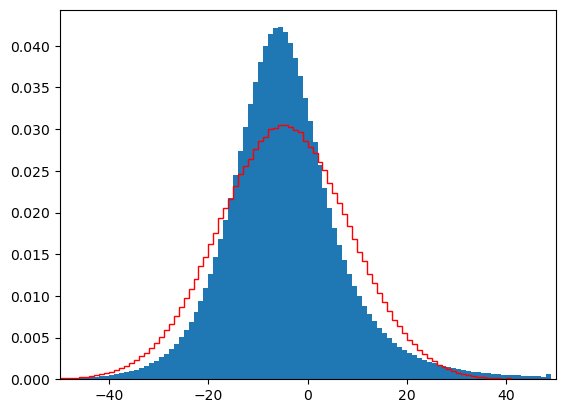

In [137]:
plt.hist(Act_vs_CRS_ET, bins=bins, density=True)
plt.hist(gauss_distr, histtype='step', bins=bins, color='r', density=True)
plt.xlim(-50,50)
plt.show()

In [138]:
print('Mean difference between scheduled and actual time', round(sample_mean, 2))
print('Standard deviation of the difference', round(sample_std, 2))

Mean difference between scheduled and actual time -4.73
Standard deviation of the difference 13.1


The diffence between acheduled and actual elapsed time is not normally distribute (despite being very close), In average the actual elapsed time less than the scheduled (-4.73 min). However, this is the duration of the flight and not a arrival time.

It is interesting to examine the most negative values of the difference between scheduled and actual elapsed time: how shorter the actual duration of flight can be against its scheduled duration?

In [139]:
flights['ElapsedTimeDiff'].astype(float).describe()

count    2.958894e+07
mean    -4.733704e+00
std      1.310128e+01
min     -2.500000e+02
25%     -1.200000e+01
50%     -6.000000e+00
75%      1.000000e+00
max      4.850000e+02
Name: ElapsedTimeDiff, dtype: float64

Interesting!!!! Some flights lasted more than 200 minutes less/more than they were scheduled!!! For sure there are errors in data.

How many flights have an elapsed time difference that is an outlier in the range?
To answer this question let's first calculate the relative difference of elapsed time, because on long distanced the absolute difference in minutes can be higher.

In [142]:
# Calculating the relative difference of elapsed time
flights['RelElapTimeDiff'] = (flights['ElapsedTimeDiff'] / flights['CRSElapsedTime']).astype(float)


In [143]:
print('Mean relative difference between scheduled and actual time (%)', round(flights['RelElapTimeDiff'].mean() * 100, 2))
print('Standard deviation of the relative difference (%)', round(flights['RelElapTimeDiff'].std() * 100, 2))

Mean relative difference between scheduled and actual time (%) -3.42
Standard deviation of the relative difference (%) 12.13


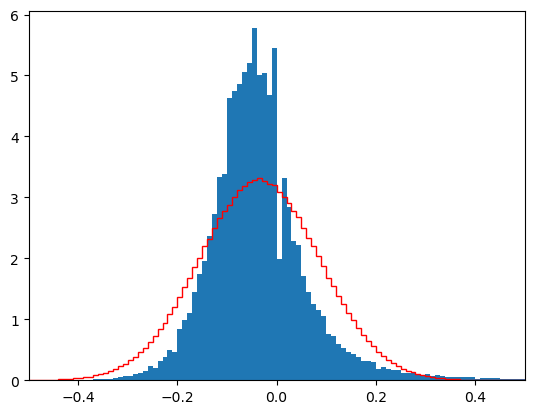

In [144]:
rng = np.random.default_rng(18)
gauss_distr = rng.normal(flights['RelElapTimeDiff'].mean(),
                        flights['RelElapTimeDiff'].std(),
                        size=1000000)

bins = np.arange(-1, 1, 0.01)

plt.hist(flights['RelElapTimeDiff'], bins=bins, density=True)
plt.hist(gauss_distr, histtype='step', bins=bins, color='r', density=True)
plt.xlim(-0.5, 0.5)
plt.show()

In [162]:

q25, q50, q75 = flights['RelElapTimeDiff'].quantile([0.25, 0.5, 0.75])
outlier_limit_low = q25 - (q75 - q25) * 1.5
outlier_limit_high = q75 + (q75 - q25) * 1.5
print('All flights with actual elapsed time less than', round(outlier_limit_low * 100, 2), 'percents or higher than', round(outlier_limit_high *100, 2), 'percents of scheduled elapsed time are deffinitely outliers')

All flights with actual elapsed time less than -25.23 percents or higher than 16.66 percents of scheduled elapsed time are deffinitely outliers


In [173]:
pd.set_option('display.width', 200)
# Filtering flights that had actual elapsed time to short relative to scheduled 
actual_time_less_than_CRRS = (flights['RelElapTimeDiff'] < outlier_limit_low) | (flights['RelElapTimeDiff'] > outlier_limit_high)

# Printing the TOP-10 fasters flights
SuperFastFlights = flights[actual_time_less_than_CRRS]
print(SuperFastFlights[['CRSDepDT',
                        'Origin', 
                        'Dest',
                        'ActualElapsedTime', 
                        'CRSElapsedTime', 
                        'ElapsedTimeDiff',
                        'RelElapTimeDiff', 
                        'diff_CRS', 'diff_Act']]
      .sort_values('RelElapTimeDiff', ascending=True).head(10))

print(SuperFastFlights[['CRSDepDT',
                        'Origin', 
                        'Dest',
                        'ActualElapsedTime', 
                        'CRSElapsedTime', 
                        'ElapsedTimeDiff',
                        'RelElapTimeDiff', 
                        'diff_CRS', 'diff_Act']]
      .sort_values('RelElapTimeDiff', ascending=True).tail(10))

# Printing some summary for these flights
print('In 2014-2018 there were', 
      SuperFastFlights['Flight_Number_Reporting_Airline'].count(), 
      'flight arrived earlier for more than', round(outlier_limit_low * 100, 2), '% (', 
      round(SuperFastFlights['Flight_Number_Reporting_Airline'].count() / len(flights) * 100, 2),
      '% of total flights)')

                    CRSDepDT Origin Dest  ActualElapsedTime  CRSElapsedTime  ElapsedTimeDiff  RelElapTimeDiff  diff_CRS  diff_Act
28530440 2018-10-09 21:20:00    ORD  TVC               60.0           -99.0            159.0        -1.606445     175.0       0.0
21568647 2017-10-09 08:55:00    SBP  SFO               52.0           302.0           -250.0        -0.827637       0.0       0.0
27060967 2018-07-17 05:40:00    SLN  HYS               44.0           161.0           -117.0        -0.726562       0.0       0.0
10814398 2015-11-03 20:15:00    SAN  SFO               84.0           285.0           -201.0        -0.705078       0.0       0.0
23159729 2018-01-07 11:10:00    RDM  MFR               41.0           137.0            -96.0        -0.700684     -60.0       0.0
24184719 2018-03-29 05:27:00    MKE  DTW               76.0           253.0           -177.0        -0.699707       0.0       0.0
24791714 2018-04-26 06:07:00    PSP  SLC               93.0           290.0           -197

In [176]:
print(SuperFastFlights[['CRSDepDT', 'CRSArrDT',
                        'CRSDep_UTC', 'CRSArr_UTC',
                        'Origin', 
                        'Dest',
                        'ActualElapsedTime', 
                        'CRSElapsedTime', 
                        'ElapsedTimeDiff',
                        'RelElapTimeDiff', 
                        'diff_CRS', 'diff_Act']]
      .sort_values('RelElapTimeDiff', ascending=True).tail(10))

                    CRSDepDT            CRSArrDT                CRSDep_UTC                CRSArr_UTC Origin Dest  ActualElapsedTime  CRSElapsedTime  ElapsedTimeDiff  RelElapTimeDiff  diff_CRS  \
16646892 2016-11-27 00:05:00 2016-11-27 01:55:00 2016-11-27 06:05:00+00:00 2016-11-27 07:55:00+00:00    ORD  FSD              574.0           110.0            464.0         4.218750       0.0   
13649647 2016-05-27 15:01:00 2016-05-27 16:00:00 2016-05-27 20:01:00+00:00 2016-05-27 21:00:00+00:00    AUS  IAH              318.0            59.0            259.0         4.390625       0.0   
22534193 2017-12-17 11:58:00 2017-12-17 13:02:00 2017-12-17 16:58:00+00:00 2017-12-17 18:02:00+00:00    AVL  ATL              370.0            64.0            306.0         4.781250       0.0   
17604178 2017-01-06 11:47:00 2017-01-06 13:04:00 2017-01-06 16:47:00+00:00 2017-01-06 18:04:00+00:00    JAX  FLL              453.0            77.0            376.0         4.882812       0.0   
26019611 2018-06-02 17:10

In [156]:
# Details for the flight ind = 21568647 which has the most significant difference between scheduled and actual 
# elapsed times

print(flights.iloc[28530440].T)
print('Flight number:', flights.iloc[28530440]['Flight_Number_Reporting_Airline'])

Reporting_Airline                                         YX
Flight_Number_Reporting_Airline                         3534
Origin                                                   ORD
Dest                                                     TVC
DepDelay                                               524.0
DepartureDelayGroups                                      12
DepTimeBlk                                         2100-2159
ArrDelay                                               508.0
ArrivalDelayGroups                                        12
ArrTimeBlk                                         2300-2359
Cancelled                                              False
CancellationCode                                         NaN
Diverted                                               False
CRSElapsedTime                                         -99.0
ActualElapsedTime                                       60.0
AirTime                                                 39.0
CarrierDelay            

In [ ]:
# Details for the flight ind = 26994453 which has the second most significant difference between scheduled and actual 
# elapsed times
print(flights.iloc[21568647][data_details + route_details + DepArr_details + elapsed_time_fields])
print('Flight number:', flights.iloc[21568647]['Flight_Number_Reporting_Airline'])


The second most differing flight has the same story: Google [search](https://www.google.com/maps/dir/LaGuardia+Airport+(LGA),+East+Elmhurst,+NY,+USA/Dallas+Fort+Worth+International+Airport+(DFW),+2400+Aviation+Dr,+Dallas,+TX+75261,+United+States/@36.3681193,-96.0279203,5z/data=!3m1!4b1!4m14!4m13!1m5!1m1!1s0x89c25f8983424db5:0x772fc4660e9666b3!2m2!1d-73.8742467!2d40.7766422!1m5!1m1!1s0x864c2a660d222aa7:0x73323f5e067d201c!2m2!1d-97.0335765!2d32.8990434!3e4?entry=ttu&g_ep=EgoyMDI0MTAwMi4xIKXMDSoASAFQAw%3D%3D) shows the estimated time of the direct flight 3h 40m which again closer to the actual elapsed time and far away from scheduled 431 min - more than 7h!

In [ ]:
# load source file for accessing some detailes that were deleted in the result dataset
_fl = load_data_from(source_zip, source_path + '2017_10.csv')

# tiltering the flight of interest 
ind = _fl[(_fl['Flight_Number_Reporting_Airline'] == 5028) 
    & (_fl['DayofMonth'] == 9) 
    & (_fl['Origin'] == 'SBP')
    & (_fl['Dest'] == 'SFO')].index
flight_top1 = _fl.iloc[*ind]

# Printing results 
pd.set_option('display.max_rows', 115)
print(_fl.iloc[*ind][:70])

In [ ]:
# load source file for accessing some detailes that were deleted in the result dataset
_fl = load_data_from(source_zip, source_path + '2018_7.csv')

# tiltering the flight of interest 
ind = _fl[(_fl['Flight_Number_Reporting_Airline'] == 5935) 
    & (_fl['DayofMonth'] == 25) 
    & (_fl['Origin'] == 'DFW')
    & (_fl['Dest'] == 'LGA')].index
flight_top2 = _fl.iloc[*ind]

# Printing results 
pd.set_option('display.max_rows', 115)
print(_fl.iloc[*ind][:70])

These two flight were quite ordinary flights: they were not canceled or diverted, they had just one flight (field 'Fligths'), and as we know from Google search above their actual elapsed time seems reasonable but their GRSElapsedTime doesn't. 

Could the CRS Elapsed Time have been calculated incorrectly due to timezone differences?
Let's check it

In [2]:
# [FUNCTION]

# The fastest flight - TOP1
def time_check(list_of_flights):
    for a in list_of_flights:
        CRSDepTime = datetime(a.Year, a.Month, a.DayofMonth, a.CRSDepTime // 100, a.CRSDepTime % 100)
        CRSArrTime = datetime(a.Year, a.Month, a.DayofMonth, a.CRSArrTime // 100, a.CRSArrTime % 100)

        print('Flight #', a.Flight_Number_Reporting_Airline)
        print('CRS: ')
        print(a.Origin, '\nTime zone: ', tz.gettz(IATAtz[a.Origin]))
        print('Local departure time:      ', CRSDepTime)
        print('Local departure time (tz): ', airport_time_tz(CRSDepTime, a.Origin))
        print('UTC Departure time:        ', airport_time_UTC(CRSDepTime, a.Origin))
        print('')
        print(a.Dest, '\nTime zone: ', tz.gettz(IATAtz[a.Dest]))
        print('Local departure time:      ', CRSArrTime)
        print('Local departure time (tz): ', airport_time_tz(CRSArrTime, a.Dest))
        print('UTC Departure time:        ', airport_time_UTC(CRSArrTime, a.Dest))
        print('')
        print('Elapsed time (CRS):', round(a.CRSElapsedTime / 60, 2))
        print('Elapsed time (UTC):', round((airport_time_UTC(CRSArrTime, a.Dest) - airport_time_UTC(CRSDepTime, a.Origin)).seconds / 3600, 2))
        print('\n')


In [ ]:
time_check([flight_top1, flight_top2])



As we can wee there is no error due to incorrect calculatinb elapsed time for different timezones of Origin and Destination. 
Let's check all outliers flights

Ok, we see that the data for the flight wiht the earliest arrival is correct. 
Let's check correctness of Elapsed times for the sample of 1000 flights

In [ ]:
# Check for correctness of CRS ET (elapsed times) for all records (rows)
from datetime import datetime

# filtering only flights that were not cancelled or diverted
not_canceled_or_diverted = (flights['Cancelled'] != 1) & (flights['Diverted'] != 1)
ordinary_flights = flights[not_canceled_or_diverted]
print('Number of not cancelled or diverted flights', len(ordinary_flights))